# 2024 DASP Student Workshop on aurora-asi-lib (asilib)

References:
- [asilib docs](https://aurora-asi-lib.readthedocs.io/en/latest/index.html) --- if you're struggling with exercises, take look at the examples and API reference
- [asilib source code](http://github.com/mshumko/aurora-asi-lib)
- [DASP Student Day Resources (e.g., this notebook)](https://github.com/kylermurphy/DASP_2024)

## Setup

Since we're running on Google Colab, we will need to install asilib. Also, to speed things up, we will point the asilib data directory to Mike's Google Drive folder that already contains the TREx data. Therefore, you normally won't need this code.

First take the asilib-data Shared Google Drive folder and make a shortcut in your personal Google Drive folder.

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Verify that the below ls command returns the trex/ folder.

In [70]:
!ls "/content/drive/My Drive/2024_dasp_asi_data/"

animations  rego  themis  trex


In [72]:
%%capture
!python -m pip install aurora-asi-lib==0.20.8

In [73]:
!yes /content/drive/My Drive/2024_dasp_asi_data/ | python -m asilib config

Running the configuration script.
What is the aurora data directory? Press enter for the default directory at ~/asilib-data folder will be created.
aurora_asi data directory at /content/drive/My Drive/2024_dasp_asi_data already exists.


In [74]:
from datetime import datetime, timedelta
import pathlib

import matplotlib.pyplot as plt
from IPython.display import Video  # to display animations in a notebook
import numpy as np

import asilib
import asilib.asi
import asilib.map

In [75]:
print(f'asilib version: {asilib.__version__}')
print(asilib.config['ASI_DATA_DIR'])

asilib version: 0.20.8
/content/drive/My Drive/2024_dasp_asi_data


## A substorm on 24 February 2023

We will use Univeristy of Calgary's Transition Region Explorer (TREx) imafers to look at the sudden brightning of the aurora during a substorm. Before we do that, here is a list of the TREx imager names and approximate locations.

In [76]:
asilib.asi.trex_rgb_info()

array location_code         name  latitude  longitude
0  TREx_RGB          ATHA    Athabasca     54.60    -113.64
1  TREx_RGB          FSMI   Fort Smith     60.03    -111.93
2  TREx_RGB          GILL       Gillam     56.38     -94.64
3  TREx_RGB          LUCK   Lucky Lake     51.15    -107.26
4  TREx_RGB          PINA       Pinawa     50.26     -95.87
5  TREx_RGB          RABB  Rabbit Lake     58.23    -103.68

## Analyzing single images

Let's first plot a fisheye lens, and its mapped projection from a TREx imager in Rabbit Lake (RABB)

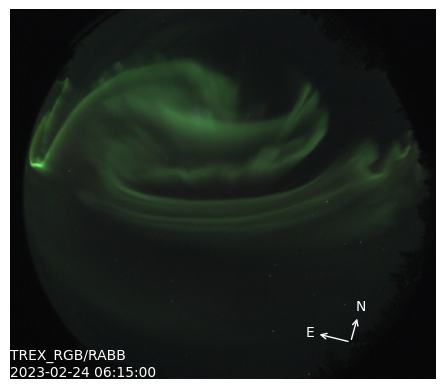

In [78]:
time = '2023-02-24T06:15'

asi = asilib.asi.trex_rgb('RABB', time=time)
asi.plot_fisheye()
plt.axis('off');

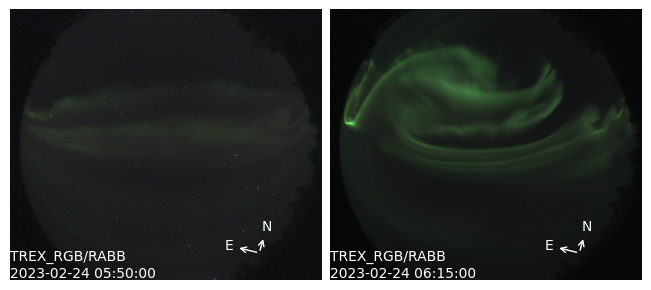

In [80]:
rabb_asi1 = asilib.asi.trex_rgb('RABB', time='2023-02-24T05:50')
rabb_asi2 = asilib.asi.trex_rgb('RABB', time='2023-02-24T06:15')

fig, ax = plt.subplots(1, 2, layout="constrained")
rabb_asi1.plot_fisheye(ax=ax[0])
rabb_asi2.plot_fisheye(ax=ax[1])

for ax_i in ax:
  ax_i.axis('off');

While the aurora was faint at 5:50 UT, it rapidly brightened, expanded in latitude, and became more complex during the substorm expansion phase. For refrence see: Akasofu, S-I. "The development of the auroral substorm." Planetary and Space Science 12.4 (1964): 273-282.

An alternative way to visualize auroral images is to project them onto a geographic map. This is done via the skymap files, provided by the instrument teams, that map each pixel vertex to a (azimuth, elevation) and (latitude, longitude, altitude) coordinates.

In asilib, plotting images on a map is relatively straighforward, but we often need to create a map subplot first.

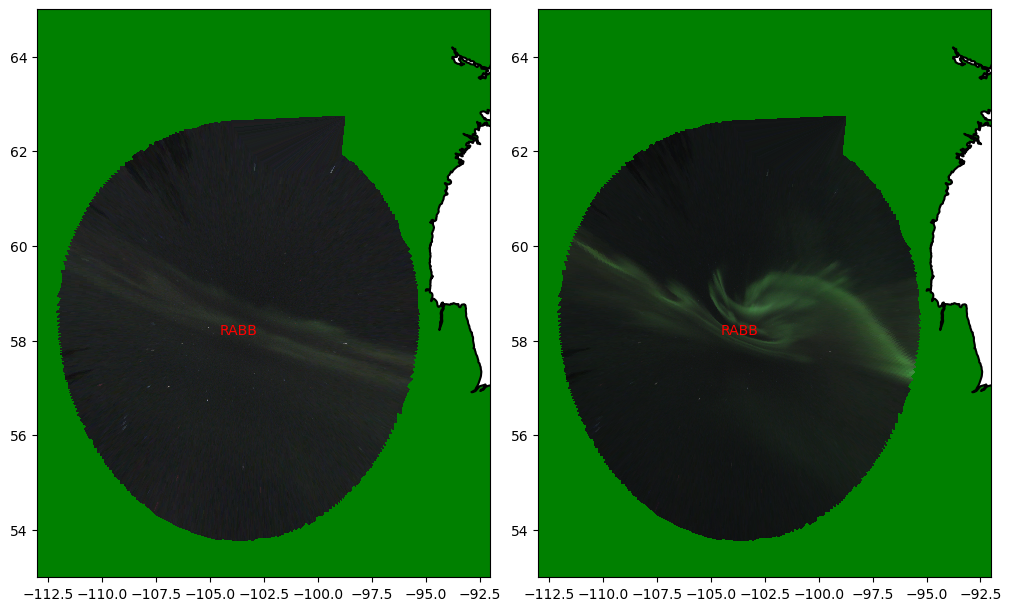

In [81]:
lat_bounds=(53, 65)
lon_bounds=(-113, -92)
fig = plt.figure(layout="constrained", figsize=(10, 6))
bx = 2*[None]
bx[0] = asilib.map.create_simple_map(fig_ax=(fig, 121), lat_bounds=lat_bounds, lon_bounds=lon_bounds)
bx[1] = asilib.map.create_simple_map(fig_ax=(fig, 122), lat_bounds=lat_bounds, lon_bounds=lon_bounds)
rabb_asi1.plot_map(ax=bx[0])
rabb_asi2.plot_map(ax=bx[1]);

## Intermission. What are classes and why should I care?

The core of asilib is `asilib.Imager`. It processes the ASI data in the same way, independent of the ASI array. Thus, you only need to learn one set of methods (i.e., a function for a class) and you can work with THEMIS, REGO, and TREx images.

A brief intro to classes:

In [84]:
class Ephemeris:
    def __init__(self, sc_id, time_range):
        """
        This class does awesome things with a satellite's ephemeris (location).
        """
        self.sc_id = sc_id
        self.time_range = time_range

    def load_data(self):
        print(f'Loading data for satellite {self.sc_id} in {self.time_range=}')
        return

    def plot_orbit(self):
        print(f'Plotting orbit for satellite {self.sc_id}.')
        return

In [85]:
sat = Ephemeris('C', ('2023-02-24T05:50', '2023-02-24T06:00'))  # JARGON ALERT: sat is an instance of class Ephemeris

In [86]:
sat.load_data()

Loading data for satellite C in self.time_range=('2023-02-24T05:50', '2023-02-24T06:00')


In [87]:
sat.plot_orbit()

Plotting orbit for satellite C.


In [88]:
print(sat.sc_id, sat.time_range)

C ('2023-02-24T05:50', '2023-02-24T06:00')


The same concepts, using classes to combine functions that share data, is at the heart of asilib's `Imager`, `Imagers` and `Conjunction` classes. For example, this is how you get the raw data from an `Imager`.

In [89]:
rabb_asi = asilib.asi.trex_rgb('RABB', time='2023-02-24T05:50')
rabb_asi.data  # a named tuple.

data(time=datetime.datetime(2023, 2, 24, 5, 50, 0, 99236), image=array([[[ 5,  5,  7],
        [ 5,  5,  6],
        [ 7,  7,  7],
        ...,
        [ 5,  7,  4],
        [ 7,  8,  4],
        [ 6,  7,  5]],

       [[ 5,  6,  7],
        [ 4,  6,  6],
        [ 6,  7,  5],
        ...,
        [ 6,  7,  5],
        [ 7,  7,  7],
        [ 6,  7,  7]],

       [[ 7,  6,  5],
        [ 5,  7,  5],
        [ 5,  6,  5],
        ...,
        [ 8,  7,  6],
        [ 9,  7,  7],
        [ 6,  5,  5]],

       ...,

       [[ 9,  8, 12],
        [ 8,  8, 12],
        [ 8,  8, 12],
        ...,
        [ 8,  7, 10],
        [ 9,  8, 10],
        [ 8,  9,  9]],

       [[ 9,  9, 12],
        [ 8,  9, 11],
        [ 8,  8, 10],
        ...,
        [ 7,  6,  6],
        [ 8,  8,  7],
        [ 6,  8,  6]],

       [[ 6,  5,  9],
        [ 6,  7,  8],
        [ 7,  7,  9],
        ...,
        [ 8,  8,  9],
        [10,  8,  9],
        [ 8,  6,  8]]], dtype=uint8))

In [90]:
rabb_asi.data.time

datetime.datetime(2023, 2, 24, 5, 50, 0, 99236)

The `asilib.Imager` methods (think of them as functions) *are*

In [91]:
[func for func in dir(asilib.Imager) if callable(getattr(asilib.Imager, func)) and not func.startswith("_")]

['animate_fisheye',
 'animate_fisheye_gen',
 'animate_map',
 'animate_map_gen',
 'iter_files',
 'keogram',
 'plot_fisheye',
 'plot_keogram',
 'plot_map']

And `asilib.Imager` attributes (think of them as variables) are

In [92]:
[func for func in dir(rabb_asi) if not callable(getattr(rabb_asi, func)) and not func.startswith("_")]

['data', 'file_info', 'meta', 'plot_settings', 'skymap']

## Animating multiple images

Working with single images does now show us how the aurora evolves. So let's see how to animate a sequence of images.

In [93]:
time_range = ('2023-02-24T05:50', '2023-02-24T06:00')

fig, ax = plt.subplots(layout='constrained')
asi = asilib.asi.trex_rgb('RABB', time_range=time_range)  # note that we specify a time_range instead of time.
asi.animate_fisheye(ax=ax, overwrite=True, animation_save_dir=pathlib.Path.home())
plt.close()

Video(str(asilib.config["ASI_DATA_DIR"] / "animations" / asi.animation_name), embed=True) # We only need to do this in a notebook.


Animation saved to /root/animations/20230224_055000_060000_trex_rgb_rabb_fisheye.mp4


### Exersise \#1

Animate the above sequence of images, but onto a geographic map


Animation saved to /content/drive/My Drive/2024_dasp_asi_data/animations/20230224_055000_060000_trex_rgb_rabb_map.mp4


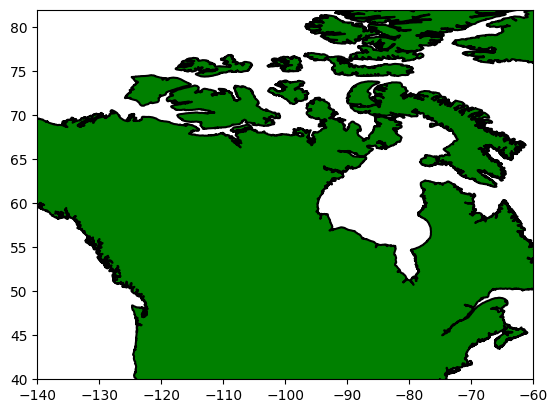

In [96]:
ax = asilib.map.create_simple_map()
asi.animate_map(ax=ax, overwrite=True, animation_save_dir=pathlib.Path.home())

## Summarizing ASI images using keograms

Viewing hours of ASI images, and from multiple imagers, rapidly becomes unwieldy. Nevertheless, you can quickly judge the quality of the ASI data using a [keogram](https://en.wikipedia.org/wiki/Keogram): a plot that summarizes a series of auroral images, taken over time. Keograms are assembled by taking a slice of pixels through each image, iterating over all of the images, and assembling the slices into a new image. The vertical axis is latitude (geographic or magnetic), and horizontal axis is time.

Keograms are essential tools for auroral physists as they summarize hours worth of auroral data into a single plot. The distinct signatures in a keogram help us discern different types of aurora and seeing conditions.

TREX_RGB RABB keogram: |####################################################################| 100%


(<Axes: title={'center': '2023-02-24 | TREX_RGB-RABB keogram'}>,
 <matplotlib.collections.QuadMesh at 0x7ce14e881ab0>)

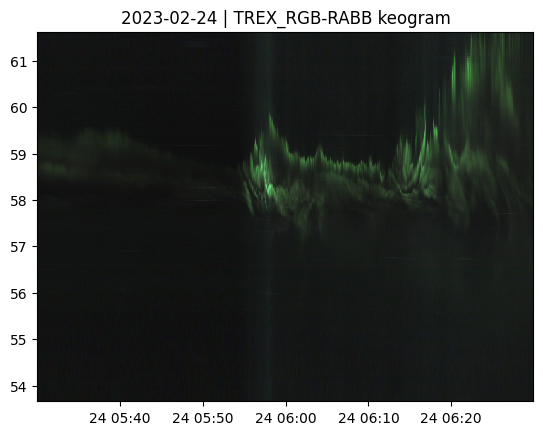

In [42]:
time_range = ('2023-02-24T05:30', '2023-02-24T06:30')

asi = asilib.asi.trex_rgb('RABB', time_range=time_range)
asi.plot_keogram()

Now we can quickly see the quiet arcs before 05:55 UT, followed by a more active substorm phase.

## Excersise \#2

Plot the same keogram, but with magnetic latitude in the vertical axis. The magnetic latitudes are calculated using the Altitude-adjusted corrected geomagnetic (AACGM) coordinates.

Citation for further reading: Shepherd, S. G. (2014), Altitude-adjusted corrected geomagnetic coordinates: Definition and functional approximations, Journal of Geophysical Research: Space Physics, 119, 7501-7521, doi:10.1002/2014JA020264.

Hint: look for the `aacgm` kwarg in the asilib docs.

TREX_RGB RABB keogram: |####################################################################| 100%


(<Axes: title={'center': '2023-02-24 | TREX_RGB-RABB keogram'}>,
 <matplotlib.collections.QuadMesh at 0x7ce157b1cf40>)

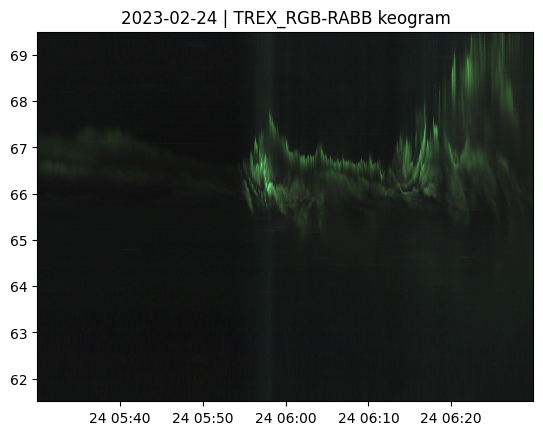

In [98]:
time_range = ('2023-02-24T05:30', '2023-02-24T06:30')

asi = asilib.asi.trex_rgb('RABB', time_range=time_range)
asi.plot_keogram(aacgm=True)

# Combine multiple ASIs into a mosaic

Here we intoroduce a sister class to `asilib.Imager` called `asilib.Imagers`. As you can probably guess, it combines multiple `asilib.Imager` objects to do cool stuff.

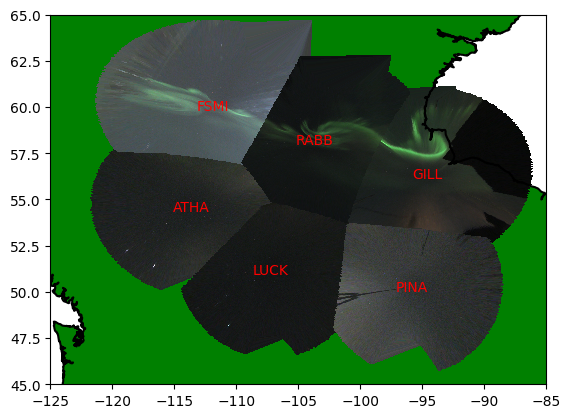

In [99]:
time='2023-02-24T06:15'
asis = asilib.Imagers(
    [asilib.asi.trex_rgb(location_code, time=time, alt=90)
    for location_code in asilib.asi.trex_rgb_info()['location_code']]
)
dx = asilib.map.create_simple_map(
    lat_bounds=(45, 65),
    lon_bounds=(-125, -85)
)
asis.plot_map(ax=dx, min_elevation=7)

## Project

I give you two options:
1. use the software you learned about today to work on your own project, if you have one, or
2. analyze a conjunction between Swarm and an ASI on 2023-02-24. Specifically, calculate the mean auroral intensity in a 10x10 km area at a 110 km altitude around the satellite's location. See this [example](https://aurora-asi-lib.readthedocs.io/en/latest/examples.html#asi-satellite-conjunction-movie) and this [tutorial](https://aurora-asi-lib.readthedocs.io/en/latest/tutorials/conjunctions.html) to get started.

Note: for project \#2, ideally you should map the satellite's location, orbiting at ~500 km altitude, along Earth's magnetic field lines to 110 km assumed auaoral emission altitude. However, this requires the [IRBEM library](https://github.com/PRBEM/IRBEM) which can be difficult to install. Don't worry about the magnetic field mapping unless you have a Fortran compiler already installed.



## Loading Data for Project \#2

We're going to utilize the [viresclient ](https://viresclient.readthedocs.io/en/latest/index.html) package to load the Swarm data. First, you'll need to make an account to download Swarm data. See this tutorial on how to make an account and generate your own [token](https://viresclient.readthedocs.io/en/latest/access_token.html).

In [45]:
%%capture
!python -m pip install viresclient
import viresclient
import pandas as pd

Lets look for conjunctions on 2023-02-24

In [60]:
viresclient.set_token(url="https://vires.services/ows")

Setting access token for https://vires.services/ows  ...
Generate a token at https://vires.services/accounts/tokens/
Enter token:··········
Token saved for https://vires.services/ows


In [61]:
request = viresclient.SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["F", "B_NEC"],
)
data = request.get_between(start_time=datetime(2023, 2, 24), end_time=datetime(2023, 2, 25))

Processing:  100%|██████████|  [ Elapsed: 00:02, Remaining: 00:00 ] [1/1] 
Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (5.621MB)


In [62]:
df = data.as_dataframe(expand=True)
R_e = 6378  # km
df['Altitude'] = df['Radius']/1E3 - R_e

In [63]:
df.head()

F   Longitude   Latitude      Radius Spacecraft  \
Timestamp                                                                       
2023-02-24 00:00:00  49015.9456  164.085370 -49.542356  6846623.19          A   
2023-02-24 00:00:01  49032.5145  164.088175 -49.605987  6846626.92          A   
2023-02-24 00:00:02  49049.0377  164.090997 -49.669617  6846630.64          A   
2023-02-24 00:00:03  49065.5070  164.093839 -49.733247  6846634.36          A   
2023-02-24 00:00:04  49081.9263  164.096698 -49.796876  6846638.07          A   

                          B_NEC_N      B_NEC_E       B_NEC_C   Altitude  
Timestamp                                                                
2023-02-24 00:00:00  11321.652551  5987.015906 -47313.282300  468.62319  
2023-02-24 00:00:01  11286.194718  5988.318149 -47338.754167  468.62692  
2023-02-24 00:00:02  11252.144012  5986.983894 -47364.138132  468.63064  
2023-02-24 00:00:03  11216.336795  5987.686261 -47389.565333  468.63436  
2023-02-24 00:00:04  11181.563325  5988.083273 -47414.773569  468.63807

Let's use `asilib.Conjunction` to first calculate the start and end time of the conjunction. Each conjunctin typically last less than 10 minutes.

In [64]:
conjunction_finder = asilib.Conjunction(
    asilib.asi.trex_rgb('GILL', time='2023-02-24', alt=90, load_images=False), # The load_images kwarg allows us to quicky calculate conjunctions without loading lots of images.
    df[['Latitude', 'Longitude', 'Altitude']]
    )

In [65]:
conjunction_df = conjunction_finder.find()
print(conjunction_df)

           start_time            end_time  start_index  end_index
0 2023-02-24 05:29:50 2023-02-24 05:30:54        19790      19854
1 2023-02-24 16:44:19 2023-02-24 16:45:23        60259      60323


And that's it! The first conjunction is during the time interval that we've plotted before.

Also, you can quickly find conjunctins using the [AuoraX Conjunction Finder](https://swarm-aurora.com/conjunctionFinder/).

Now let's calculate the auroral intensity around Swarm's location.

In [66]:
conjunction_time_range = conjunction_df.loc[0, ['start_time', 'end_time']].to_numpy()
# Pad the start and end times so Swarm gets close to the horizon.
conjunction_time_range[0] = conjunction_time_range[0]-timedelta(minutes=2)
conjunction_time_range[1] = conjunction_time_range[1]+timedelta(minutes=2)
swarm_conjunction_ephem = df.loc[conjunction_time_range[0]:conjunction_time_range[1], ['Latitude', 'Longitude', 'Altitude']]
conjunction_obj = asilib.Conjunction(
    asilib.asi.trex_rgb('GILL', time_range=conjunction_time_range, alt=110), swarm_conjunction_ephem
    )
conjunction_obj.interp_sat()  # This is needed to align the Swarm and ASI time stamps.

lat        lon         alt
2023-02-24 05:27:51.100480  46.739618 -98.466954  455.491205
2023-02-24 05:27:54.283231  46.942983 -98.460161  455.454982
2023-02-24 05:27:57.215422  47.130337 -98.453767  455.421687
2023-02-24 05:28:00.043822  47.311057 -98.447476  455.389654
2023-02-24 05:28:03.244081  47.515534 -98.440205  455.353484
...                               ...        ...         ...
2023-02-24 05:32:39.092689  65.120149 -96.768354  452.674976
2023-02-24 05:32:42.279397  65.323075 -96.728039  452.650155
2023-02-24 05:32:45.194363  65.508680 -96.690439  452.627600
2023-02-24 05:32:48.039911  65.689850 -96.653049  452.605704
2023-02-24 05:32:51.240119  65.893581 -96.610156  452.581243

[101 rows x 3 columns]

Let's see where the sattelite was in the ASIs field of view

In [67]:
sat_azel, sat_azel_pixels = conjunction_obj.map_azel()

[Text(0, 0.5, 'Elevation')]

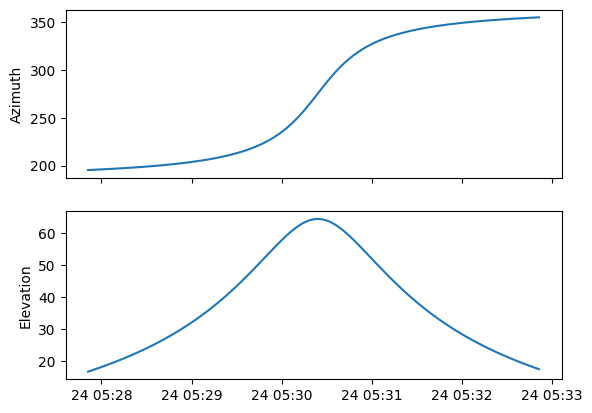

In [68]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(conjunction_obj.sat.index, sat_azel[:, 0], label='Azimuth')
ax[1].plot(conjunction_obj.sat.index, sat_azel[:, 1], label='Elevation')
ax[0].set(ylabel='Azimuth')
ax[1].set(ylabel='Elevation')

Now calculate the auroral intensity and animate the conjunction (closely following this [tutorial](https://aurora-asi-lib.readthedocs.io/en/latest/tutorials/conjunctions.html)).